In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import join
import operator

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [139]:
class BabyNames(object):    
    def __init__(self, path): 
        newlist = []
        columns = ['state','sex','year', 'name', 'occurances']

        for filename in os.listdir(path):
            if filename.endswith('.TXT'):
                df = pd.read_csv(join(path, filename), names=columns)
                newlist.append(df)
        self.names = pd.concat(newlist,ignore_index = True)
        
        def add_prop(group):
            group['prop'] = group.occurances / group.occurances.sum()
            return group
    
        self.names = self.names.groupby(['year','state']).apply(add_prop)
    
    def Count(self, state = '', year = ''): 
        if state == '': 
            state = self.names.state
        if year == '':
            year = self.names.year
        return(self.names[(self.names.state.isin([state])) & (self.names.year.isin([year]))]['occurances'].sum())
        
    
    def Top10BabyNames(self, state ='', year = ''):
        if state == '': 
            state = self.names.state
        if year == '':
            year = self.names.year
        t = self.names[(self.names.state.isin([state])) & (self.names.year.isin([year]))]                                              
        data = {'Male': t[t.sex == "M"].groupby('name').sum().sort_values(by = 'occurances', ascending = False).head(10).index.values,
                'Female': t[t.sex == "F"].groupby('name').sum().sort_values(by = 'occurances', ascending = False).head(10).index.values
            }
        df = pd.DataFrame(data, index = range(1,11))
        df.index.name = "Rank"
        return(df)
        
    def ChangeOfPopularity(self, fromYear=2014, toYear=2015, top=10):
        fromYear = self.names[self.names.year == fromYear][['name', 'occurances']].groupby('name').sum()
        toYear = self.names[self.names.year == toYear][['name', 'occurances']].groupby('name').sum()
        year2year = pd.merge(fromYear, toYear, right_index=True, left_index=True)
        year2year['diff'] = year2year['occurances_y'] - year2year['occurances_x']
        popularNames = toYear.sort_values(by = 'occurances', ascending = False).head(top).index.values
        morePopular = year2year.sort_values(by = 'diff', ascending = False).head(top).index.values
        lessPopular = year2year.sort_values(by = 'diff').head(top).index.values
        return "Names that increased in popularity: ", morePopular, "Names that decreased in popularity: ",\
                lessPopular, "Names that are popular (by rank): ", popularNames
        
        
    def Top5NamesPerYear(self, year=2015,sex=''):
        if sex == '':
            sex = self.names.sex
        df = self.names[(self.names.year == year) & (self.names.sex.isin([sex]))][["state", "name", "occurances"]]
        df = df.sort_values(by = ["occurances"], ascending = False).groupby("state").head(5)
        df = df.sort_values(by = ["state", "occurances"], ascending = [True, False]).reset_index(drop = True)
        df["Ranks"] = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5'] * 51

        result = {"State": self.names.state.unique(), 
                  "Rank1": df[df.Ranks == "Rank 1"]["name"].values,"Rank1 Num": df[df.Ranks == "Rank 1"]["occurances"].values, 
                  "Rank2": df[df.Ranks == "Rank 2"]["name"].values,"Rank2 Num": df[df.Ranks == "Rank 2"]["occurances"].values,
                  "Rank3": df[df.Ranks == "Rank 3"]["name"].values,"Rank3 Num": df[df.Ranks == "Rank 3"]["occurances"].values,
                  "Rank4": df[df.Ranks == "Rank 4"]["name"].values,"Rank4 Num": df[df.Ranks == "Rank 4"]["occurances"].values,
                  "Rank5": df[df.Ranks == "Rank 5"]["name"].values,"Rank5 Num": df[df.Ranks == "Rank 5"]["occurances"].values}
        result = pd.DataFrame(result).set_index("State")
        return(result)

    
    def NamePopularityPlot(self, name='Jim', yearRange=(2000,2015), state='IL', sex='M'):
        startYear = yearRange[0]
        endYear = yearRange[1]
        
        years = []
        props = []
        for year in range(startYear, endYear + 1):
            years.append(year)
            if self.names[(self.names.name == name) & (self.names.year == year) &\
                           (self.names.state == state)][['prop']].empty:
                props.append(0.0)
            else:
                props.append(self.names[(self.names.name == name) & (self.names.year == year) &\
                                        (self.names.state == state)][['prop']].iloc[0])
        plt.bar(years, props)
        plt.xlabel('Year')
        plt.ylabel('Proportion')
        plt.title('Change of Proportion of Birth Name')
        
    def NameFlip(self, n=10):
        # make dataframe of unisex names by year
        unisex = self.names.groupby(['year','name','sex']).sum()
        unisex = unisex.reset_index()
        unisex = unisex[unisex.duplicated(['name', 'year'], keep = False)]
        
        sort = unisex.sort_values(by = ['year', 'name', 'prop'], ascending = [True, True, False])
        sort = sort.reset_index(drop = True)
        sort = sort.iloc[::2]
        
        # identify each leading gender for each name by year, store as list in dictionary 
        swaps = {}
        for name in sort.name.unique():
            swaps[name] = list(sort[sort.name == name].sex.values)
                
       #find the names that did, in fact, swap
        swappers = []
        for key in swaps.keys():
            if(len(set(swaps[key])) == 2):
                swappers.append(key) 
       
        final = {}
        for name in swappers: 
            final[name] = 0
        
        # make nested dict with swapping names and years they swapped
        for name in swappers:
            lead = swaps[name][0]
            counter = 0
            for i in range(len(swaps[name])):
                if(lead != swaps[name][i]):
                    counter = counter + 1
                    lead = swaps[name][i]
            final[name] = counter
        
        top = sorted(final, key=final.get, reverse = True)[0:n]
        for i in range(n):
            table = test.names[test.names.name == top[i]].pivot_table(values='prop', index=['year'], columns=['sex', 'name'], aggfunc=sum)
            table.plot(style={'M': 'k-', 'F': 'k--'})
            plt.ylabel('Proportion')
            plt.xlabel('Year')

In [140]:
mypath = '/Users/sarahgreenwood/Downloads/namesbystate/'
test = BabyNames(mypath)

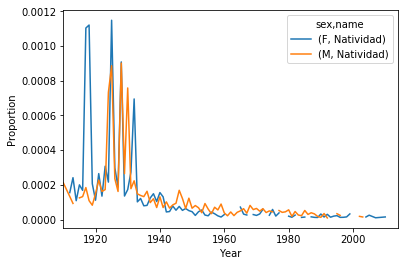

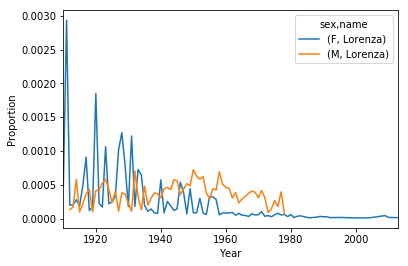

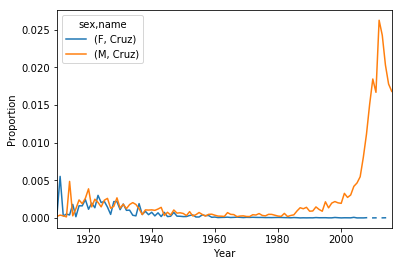

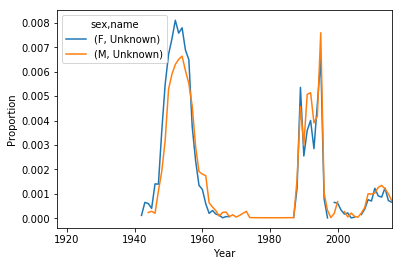

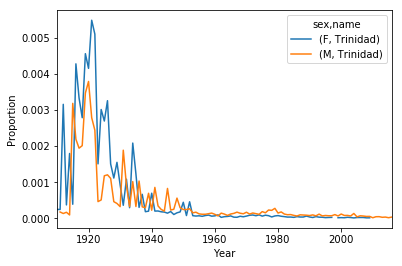

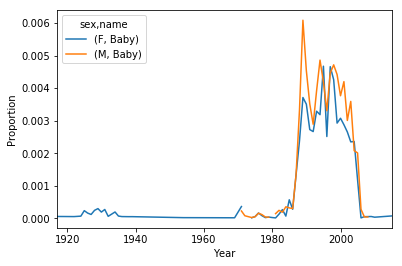

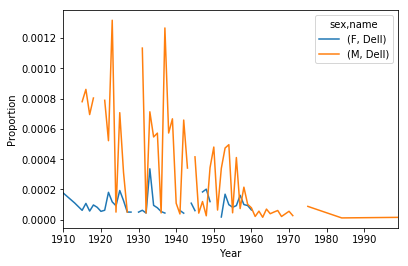

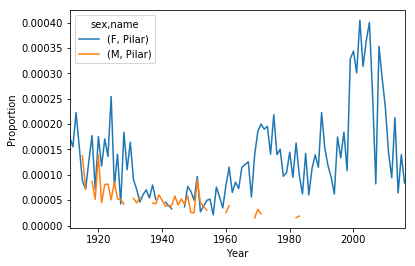

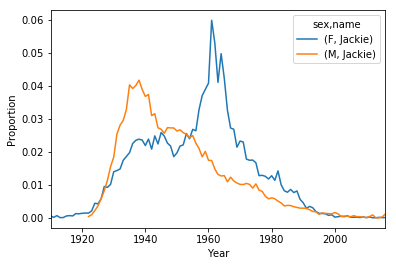

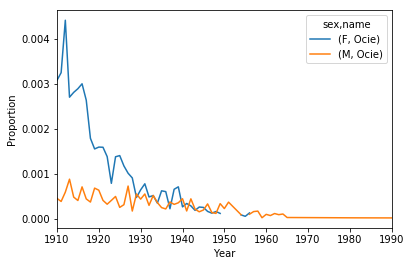

In [141]:
test.NameFlip()